# Clustering

## Importing libraries

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
np.random.seed(4)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import pathlib
import json
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from umap import UMAP

## Clustering progressive passes

### Opening data

In [2]:
# Loading and storing data into data frame
path = r"D:\WyScoutOpenData\events\events_England.json"
with open(path) as f:
    data = json.load(f)
df = pd.DataFrame(data)

### Preparing the dataset

In [3]:
# Getting events from match
match_id = 2500045

# Getting passes from this match
match_events = df.loc[df["matchId"] == match_id]
next_event = match_events.shift(-1, fill_value=0)
match_events["nextEvent"] = next_event["subEventName"]
match_events["kickedOut"] = match_events.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)
passes = match_events.loc[match_events["eventName"] == "Pass"]

# Changing coordinatess to better find progressive
passes["x"] = passes.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
passes["y"] = passes.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
passes["end_x"] = passes.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
passes["end_y"] = passes.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)
delete_passes = passes.loc[passes["kickedOut"] == 1]
passes = passes.drop(delete_passes.index)
passes = passes.loc[(((passes["end_x"] != 0) & (passes["end_y"] != 68)) & ((passes["end_x"] != 105) & (passes["end_y"] != 0)))]

### Finding out progressive passes

In [4]:
def is_progressive(x, y, end_x, end_y):
    start_dist = np.sqrt((105 - x)**2 + (34 - y)**2)
    end_dist = np.sqrt((105 - end_x)**2 + (34 - end_y)**2)
    
    # Marking that passes to own half are not progressive
    thres = 100
    if x < 52.5 and end_x < 52.5:
        thres = 30
    elif x < 52.5 and end_x >= 52.5:
        thres = 15
    elif x >= 52.5 and end_x >= 52.5:
        thres = 10
    if thres > start_dist - end_dist:
        return False
    else:
        return True

passes["is_progressive"] = passes.apply(lambda row : is_progressive(row['x'], row['y'], row['end_x'], row['end_y']), axis = 1)

# Keeping Manchester United progressive passes
united_passes = passes.loc[passes["teamId"] != 1625]
united_progressive = united_passes.loc[united_passes["is_progressive"] == True]

united_progressive["angle"] = np.arctan2(united_progressive["end_y"] - united_progressive["y"], united_progressive["end_x"] - united_progressive["x"])

### Finding out optimal number of clusters

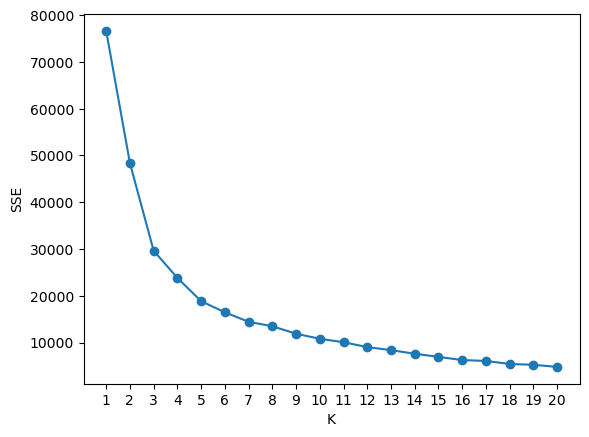

Text(0.5, 0, 'k')

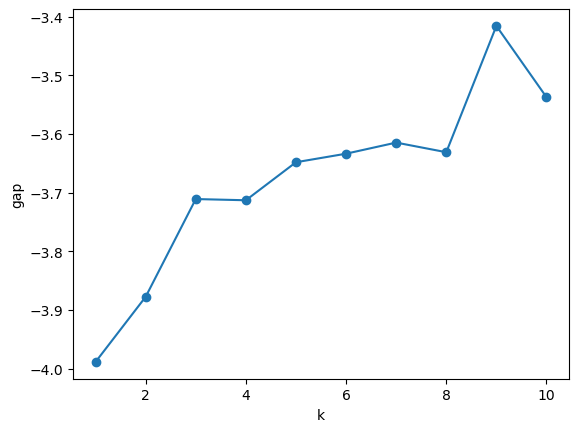

In [5]:
K = np.linspace(1, 20, 20)
X = united_progressive[["x", "y", "end_x", "end_y", "angle"]].values
elbow = {"sse": [], "k": [], "sil": []}
for k in K:
    cluster = KMeans(n_clusters = int(k), random_state = 2147)
    labels = cluster.fit_predict(X)
    elbow["sse"].append(cluster.inertia_)
    elbow["k"].append(k)

plt.scatter(elbow["k"], elbow["sse"])
plt.plot(elbow["k"], elbow["sse"])
plt.xticks(np.linspace(1, 20, 20))
plt.xlabel("K")
plt.ylabel("SSE")
plt.show()

def compute_inertia(a, X):
    W = [np.mean(pairwise_distances(X[a == c, :])) for c in np.unique(a)]
    return np.mean(W)

def compute_gap(clustering, data, k_max, n_references=5):
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    reference = np.random.rand(*data.shape)
    reference_inertia = []
    for k in range(1, k_max+1):
        local_inertia = []
        for _ in range(n_references):
            clustering.n_clusters = k
            assignments = clustering.fit_predict(reference)
            local_inertia.append(compute_inertia(assignments, reference))
        reference_inertia.append(np.mean(local_inertia))

    ondata_inertia = []
    for k in range(1, k_max+1):
        clustering.n_clusters = k
        assignments = clustering.fit_predict(data)
        ondata_inertia.append(compute_inertia(assignments, data))

    gap = np.log(reference_inertia)-np.log(ondata_inertia)
    return gap, np.log(reference_inertia), np.log(ondata_inertia)

k_max = 10
gap, reference_inertia, ondata_inertia = compute_gap(KMeans(random_state = 2147), X, k_max)

plt.plot(range(1, k_max+1), gap, '-o')
plt.ylabel('gap')
plt.xlabel('k')

### Clustering

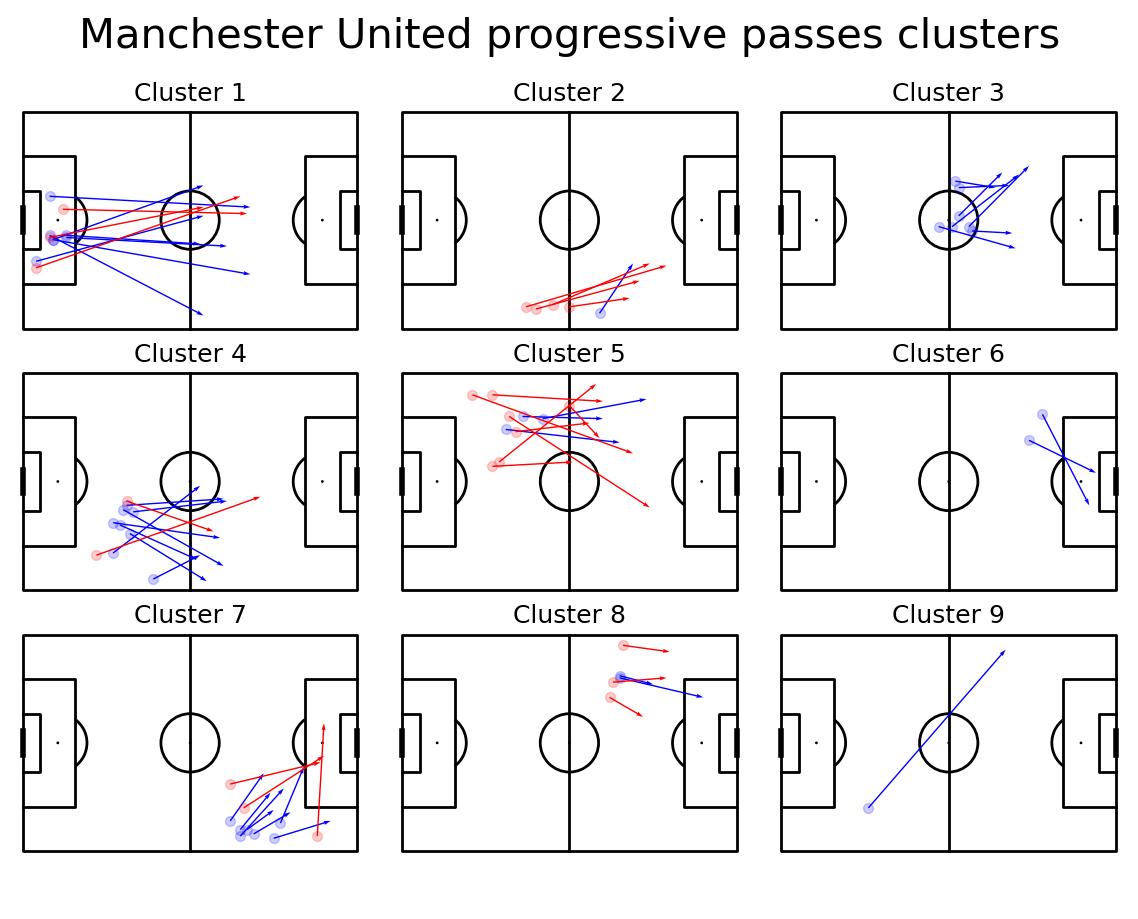

In [6]:
# Defining the number of clusters
k = 9
cluster = KMeans(n_clusters = int(k), random_state = 2147)
labels = cluster.fit_predict(X)

united_progressive["label"] = labels

pitch = Pitch(line_color='black', pitch_type = "custom", pitch_length=105, pitch_width=68)
fig, axs = pitch.grid(ncols = 3, nrows = 3, grid_height=0.85, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0.04, endnote_space=0.01)

# Looping for each player
for clust, ax in zip(np.linspace(0, k-1, k), axs['pitch'].flat[:k]):
    # Putting player name over the plot
    ax.text(52.5, 74, "Cluster " + str(int(clust+1)),
            ha='center', va='center', fontsize=18)
    
    # Taking only passes by this player
    clustered = united_progressive.loc[united_progressive["label"] == clust]
    
    # Scattering
    correct = clustered.loc[clustered.apply (lambda x:{'id':1801} in x.tags, axis = 1)]
    pitch.scatter(correct.x, correct.y, alpha = 0.2, s = 50, color = "blue", ax=ax)
    
    # Plotting arrow
    pitch.arrows(correct.x, correct.y,
            correct.end_x, correct.end_y, color = "blue", ax=ax, width=1)
    incorrect = clustered.loc[clustered.apply (lambda x:{'id':1802} in x.tags, axis = 1)]
    pitch.scatter(incorrect.x, incorrect.y, alpha = 0.2, s = 50, color = "red", ax=ax)
    
    # Plotting arrow
    pitch.arrows(incorrect.x, incorrect.y,
            incorrect.end_x, incorrect.end_y, color = "red", ax=ax, width=1)

# Setting title
axs['title'].text(0.5, 0.5, 'Manchester United progressive passes clusters', ha='center', va='center', fontsize=30)
plt.show()

## Clustering players

### Preparing the dataset

In [7]:
# Opening data
data = pd.read_csv(r"D:\FBRefTop5LeaguesPlayerData.csv")

# Changing minutes to numerics
data["Min"] = data["Min"].apply(lambda x: x.replace(",", "")).astype(int)

data = data.loc[data["Min"] > 500]
data = data.reset_index(drop = True)
data = data._convert(numeric=True)
data = data.fillna(0)
X = data.iloc[:, 11:]

### Dimensionality reduction

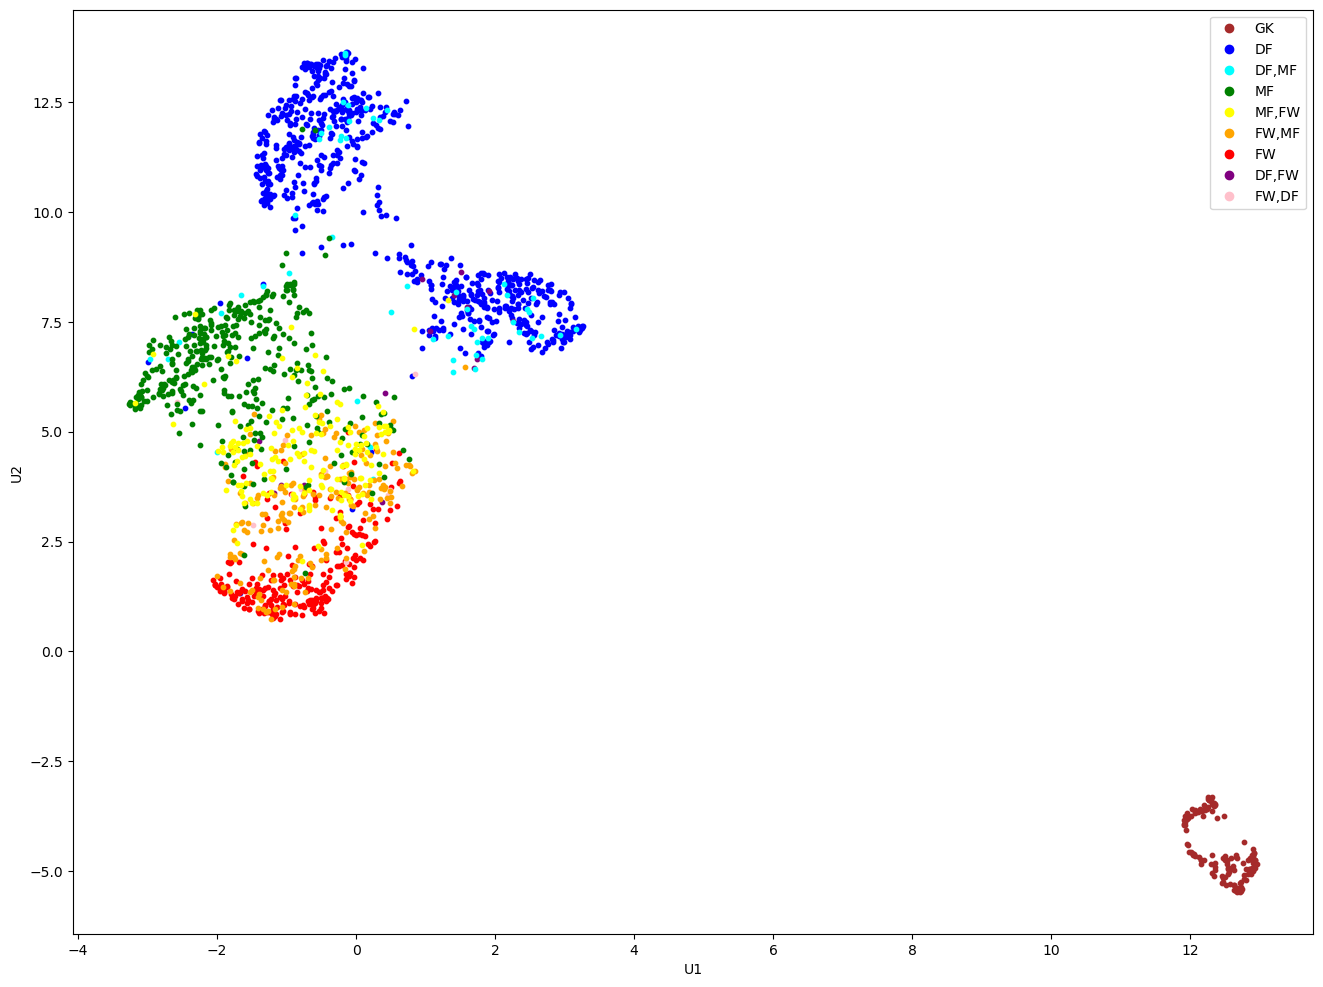

In [8]:
# Scaling data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reducting dimension
reducer = UMAP(random_state = 2213)
comps = reducer.fit_transform(X)

# Plotting
fig, ax = plt.subplots(figsize = (16,12))
#map position to color
colors = {"GK": "brown", "DF": "blue", "DF,MF": "aqua", "MF": "green", "MF,FW": "yellow", "FW,MF": "orange", "FW": "red", 'DF,FW': "purple", 'FW,DF': "pink"}
color_list = data.Pos.map(colors).to_list()

#plot it
for i in range(X.shape[0]):
    ax.scatter(comps[i,0], comps[i,1], c = color_list[i], s = 10)
ax.set_xlabel('U1')
ax.set_ylabel('U2')
#make legend
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
ax.legend(markers, colors.keys(), numpoints=1)
plt.show()

### Clustering

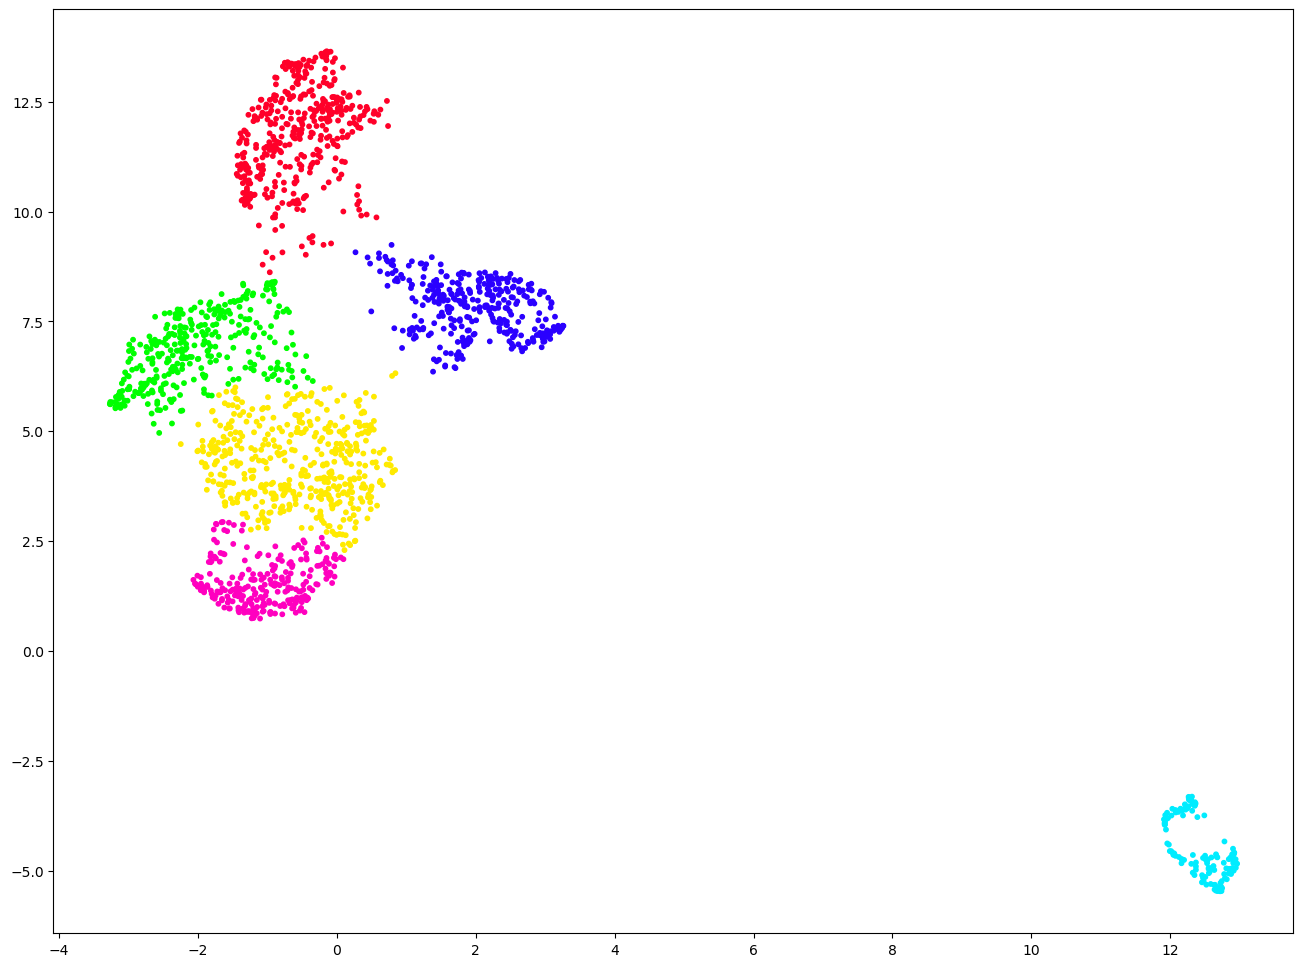

In [9]:
# Declaring object
scan = AgglomerativeClustering(n_clusters=6)

# Making predictions
labels = scan.fit_predict(comps)
fig, ax = plt.subplots(figsize = (16,12))
ax.scatter(comps[:, 0], comps[:, 1], c=labels, s=10, cmap='gist_rainbow');
plt.show()

### Labelling clusters

              Player   Nation    Pos          Squad                Comp  label
70       Sven Bender   de GER     DF     Leverkusen       de Bundesliga      0
1883    Adam Lallana  eng ENG  MF,FW       Brighton  eng Premier League      2
1023     Charles Abi   fr FRA  FW,MF  Saint-Étienne          fr Ligue 1      5
1661      Luis Rioja   es ESP     MF         Alavés          es La Liga      1
742       Gary Medel   cl CHI  DF,MF        Bologna          it Serie A      0
1401    Sander Berge   no NOR     MF  Sheffield Utd  eng Premier League      1
1796    Carles Aleñá   es ESP  MF,FW         Getafe          es La Liga      1
229   Davide Faraoni   it ITA     DF  Hellas Verona          it Serie A      4
1222         Alisson   br BRA     GK      Liverpool  eng Premier League      3
129     Fouad Chafik   ma MAR     DF          Dijon          fr Ligue 1      4


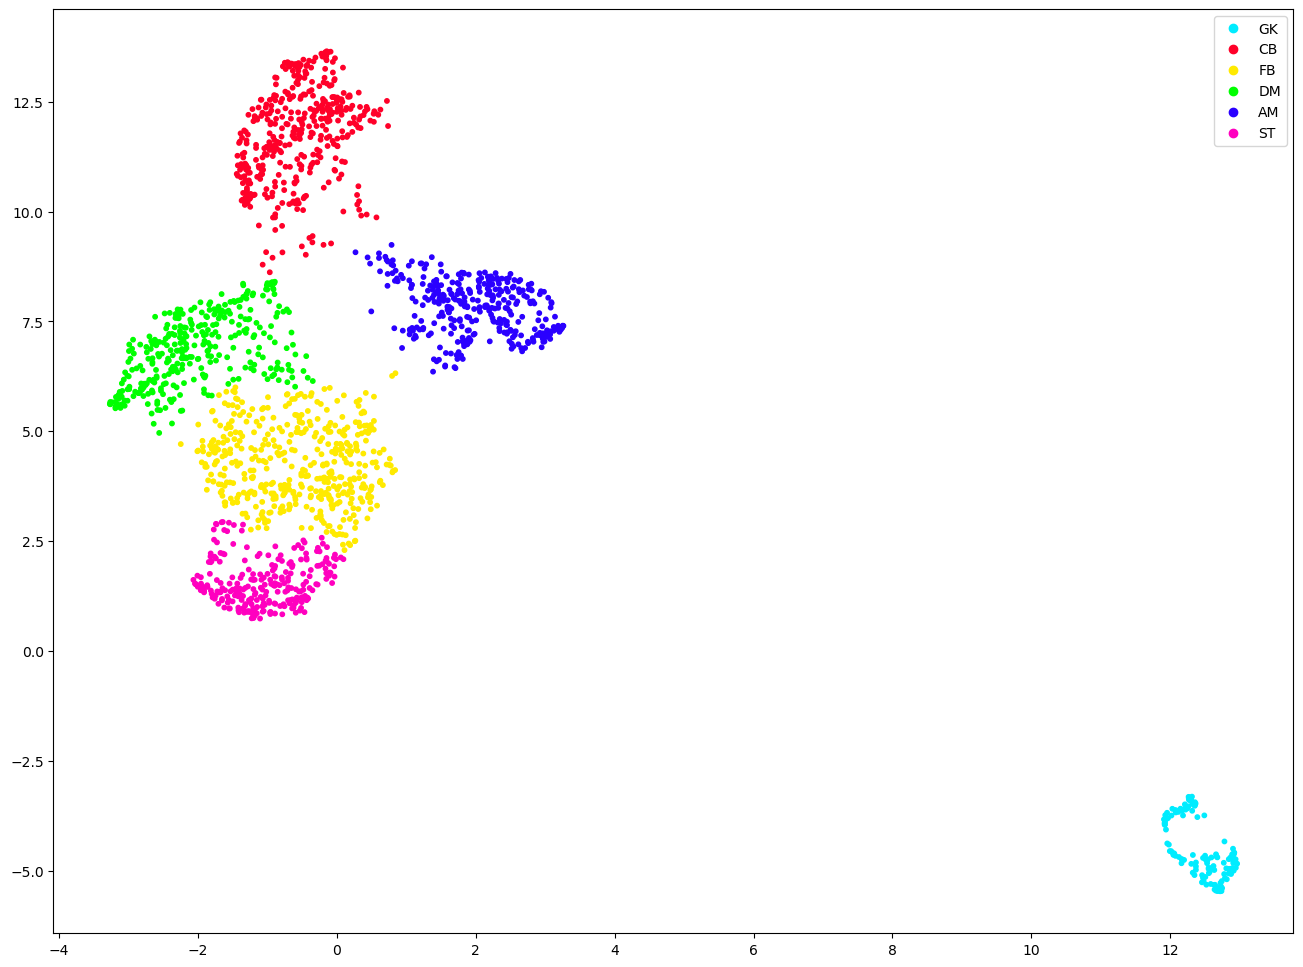

In [10]:
# Exploring the dataframe
see = data.iloc[:, 0:5]
see["label"] = labels
print(see.sample(frac = 1).head(10))

# Plotting predictions with a legend
fig, ax = plt.subplots(figsize = (16,12))
scatter = ax.scatter(comps[:, 0], comps[:, 1], c=labels, s=10, cmap='gist_rainbow');
handles = scatter.legend_elements()[0]

# Ordering the labels for hierarchy
myorder = [3,0,1,2,4,5]
handles = [handles[i] for i in myorder]

# Adding legend
ax.legend(handles=handles, labels = ["GK", "CB", "FB", "DM", "AM", "ST"])
plt.show()

### A different approach to the same problem

#### Dimensionality reduction

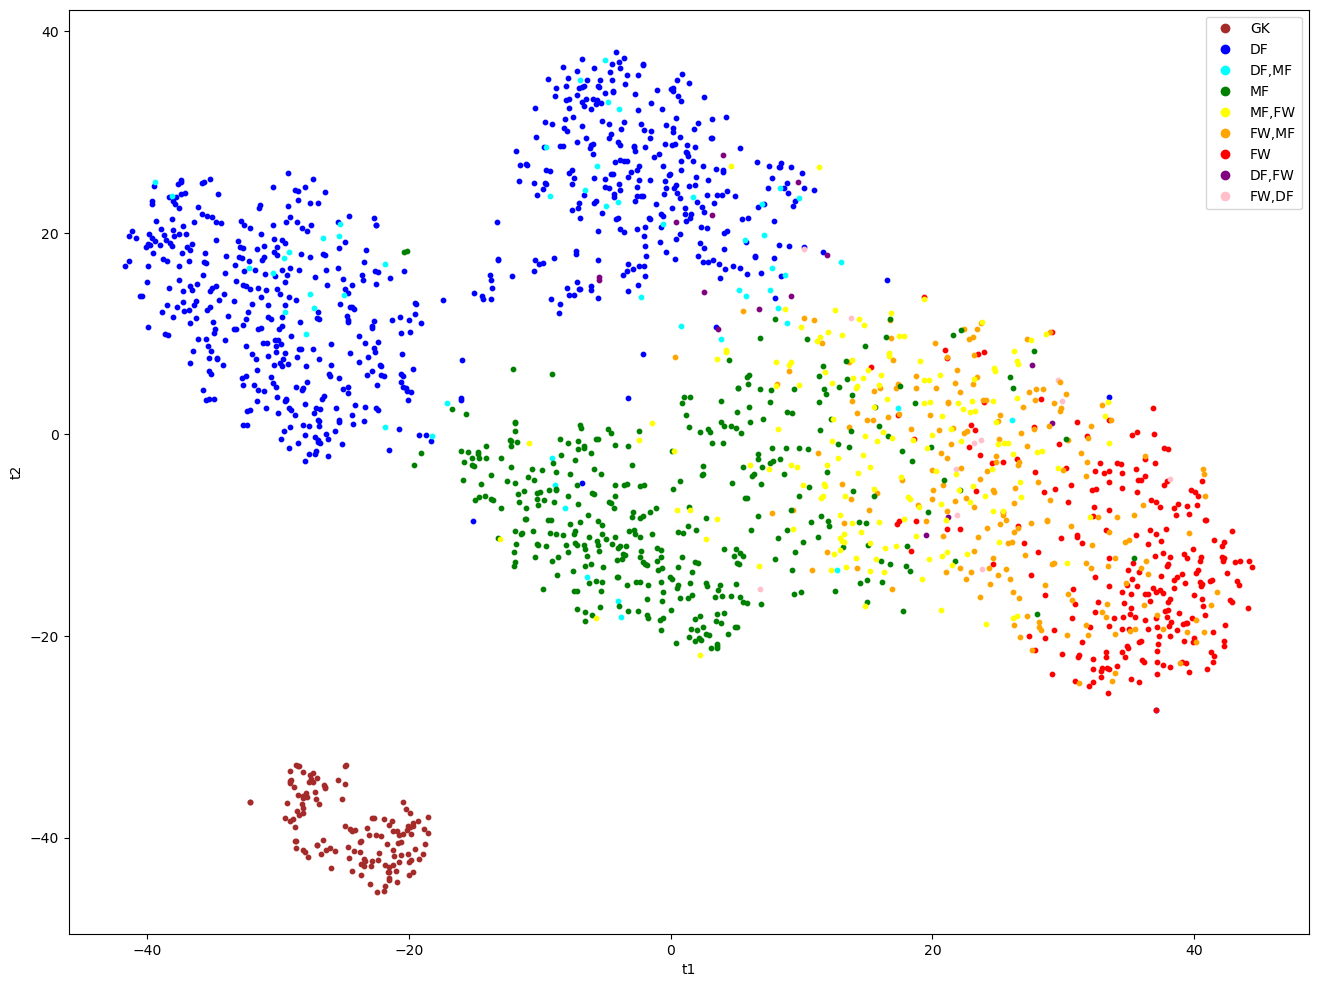

In [11]:
# Declaring dimension reduction objects
pca = PCA()
tsne = TSNE(random_state = 3454)

# Declaring pipeline
ts = Pipeline([    ('pca', pca),
    ('tsne', tsne)
])

# Reducing dimensions
comps = ts.fit_transform(X)

# Plotting data
fig, ax = plt.subplots(figsize = (16,12))
for i in range(X.shape[0]):
    ax.scatter(comps[i,0], comps[i,1], c = color_list[i], s = 10)
ax.set_xlabel('t1')
ax.set_ylabel('t2')
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colors.values()]
ax.legend(markers, colors.keys(), numpoints=1)
plt.show()

#### Clustering

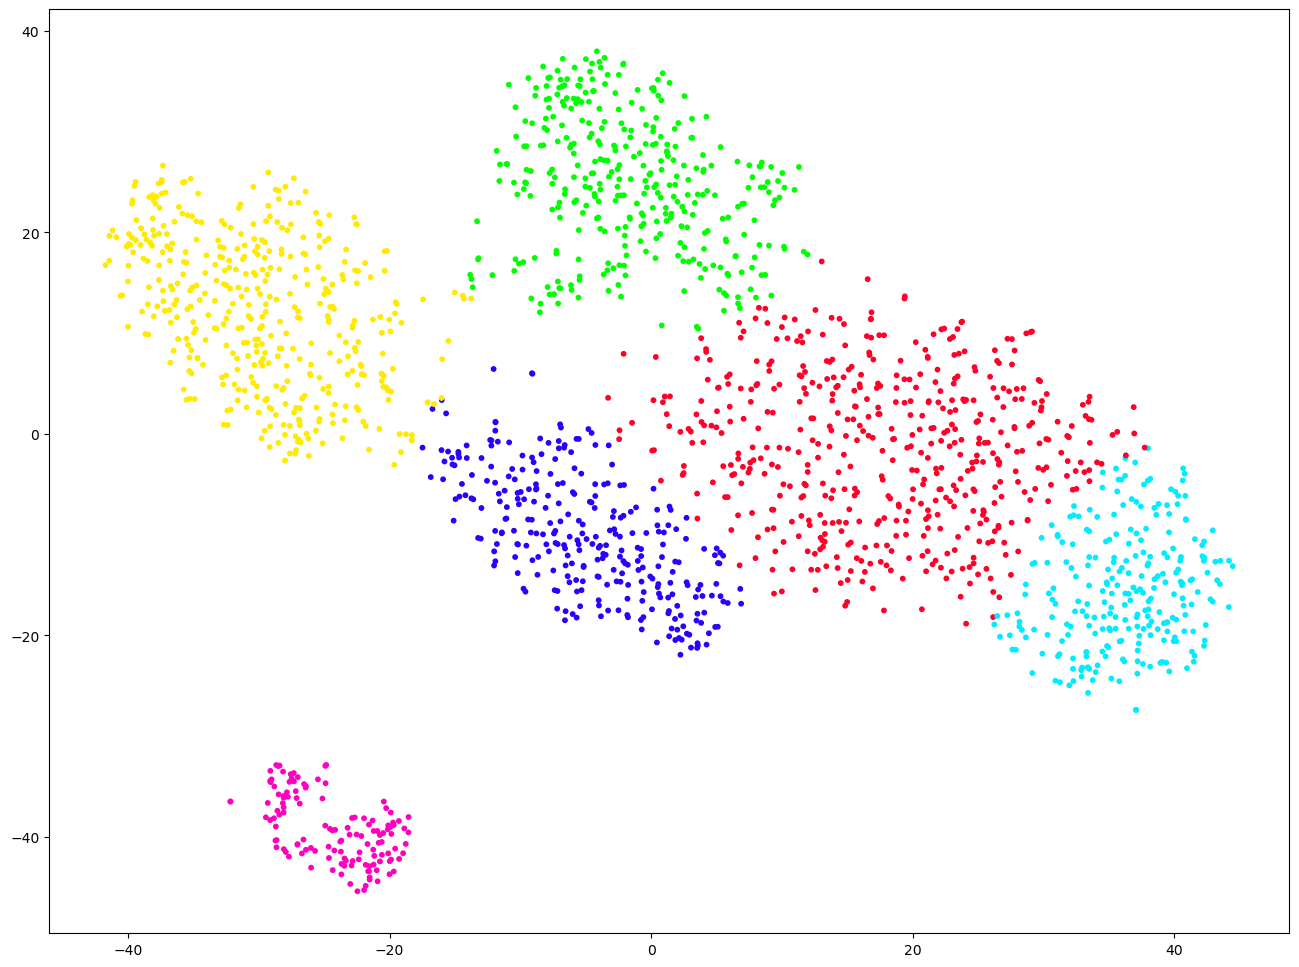

In [12]:
# Declaring object
gmm = GaussianMixture(n_components=6, random_state=5).fit(comps)

# Making predictions
labels = gmm.predict(comps)
fig, ax = plt.subplots(figsize = (16,12))
plt.scatter(comps[:, 0], comps[:, 1], c=labels, s=10, cmap='gist_rainbow');
plt.show()

#### Labelling

                Player   Nation    Pos       Squad                Comp  label
1278    Eiji Kawashima   jp JPN     GK  Strasbourg          fr Ligue 1      5
142        Conor Coady  eng ENG     DF      Wolves  eng Premier League      1
477     Phillipp Mwene   at AUT     DF    Mainz 05       de Bundesliga      2
910        Roger Martí   es ESP     FW     Levante          es La Liga      3
93    Anthony Briançon   fr FRA     DF       Nîmes          fr Ligue 1      1
580       Samir Santos   br BRA     DF     Udinese          it Serie A      1
589     Djibril Sidibé   fr FRA     DF      Monaco          fr Ligue 1      2
1565   Giulio Maggiore   it ITA     MF      Spezia          it Serie A      0
1831  Samuel Chukwueze   ng NGA  MF,FW  Villarreal          es La Liga      0
1841      Sofiane Diop   fr FRA  MF,FW      Monaco          fr Ligue 1      0


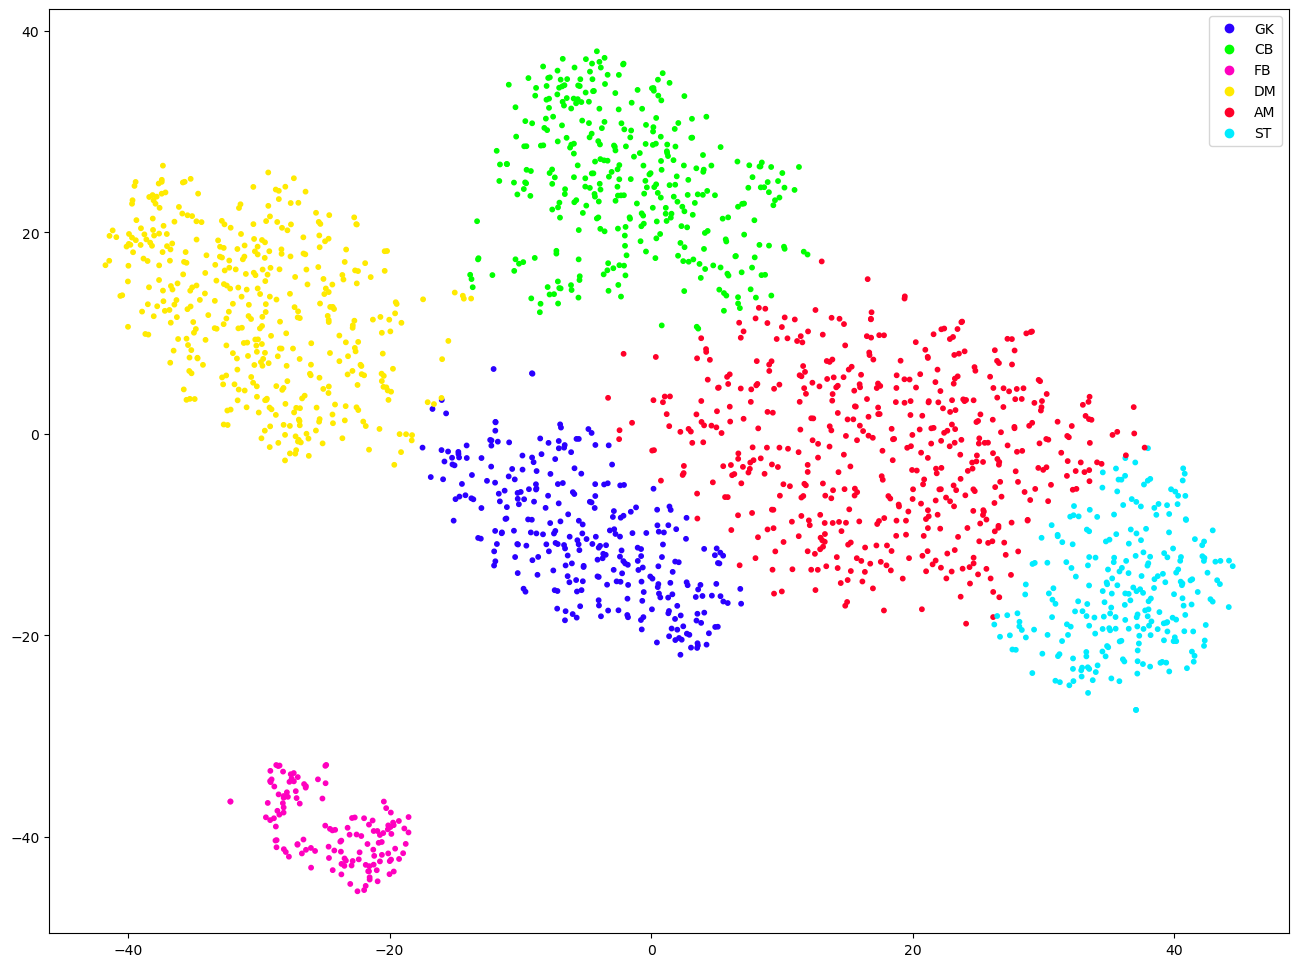

In [13]:
see = data.iloc[:, 0:5]
see["label"] = labels
print(see.sample(frac = 1).head(10))

# Exploring the dataframe
fig, ax = plt.subplots(figsize = (16,12))
scatter = ax.scatter(comps[:, 0], comps[:, 1], c=labels, s=10, cmap='gist_rainbow');
handles = scatter.legend_elements()[0]

# Ordering the labels for hierarchy
myorder = [4,2,5,1,0,3]
handles = [handles[i] for i in myorder]
ax.legend(handles=handles, labels = ["GK", "CB", "FB", "DM", "AM", "ST"])
plt.show()